In [10]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import sys
import numba as nb

In [11]:
url='https://www.janestreet.com/puzzles/knight-moves-2/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.  (Squares are “connected” if they border one another horizontally or vertically. The solution for Tile and Trouble contains a similar example.)


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2017/04/Apr17__puzzle.png" width="500">

Inital Setup
~~~~~~~~~~~~


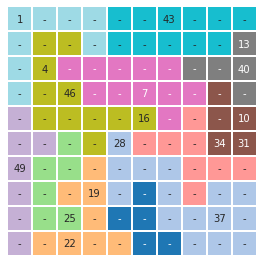

In [12]:
# Setup the constraints
# Smallest group has 5 cells.
# 12 hooks so max moves = 60
# so 6 in each row and col

groups =np.array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
                  [0, 2, 2, 0, 1, 1, 1, 1, 1, 3],
                  [0, 2, 4, 4, 4, 4, 4, 3, 3, 3],
                  [0, 2, 2, 4, 4, 4, 4, 4, 5, 3],
                  [6, 2, 2, 2, 2, 2, 4, 7, 5, 5],
                  [6, 6, 8, 2,10, 7, 7, 7, 5, 5],
                  [6, 8, 8, 9,10,10,10, 7, 7, 7],
                  [6, 8, 9, 9,10,11,10, 7,10,10],
                  [6, 8, 8, 9,11,11,10,10,10,10],
                  [6, 9, 9, 9, 9,11,11,10,10,10]
                 ],dtype=int)

fixed =np.array([[ 1,  0,  0,  0,  0,  0, 43,  0,  0,  0],
                 [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13],
                 [ 0,  4,  0,  0,  0,  0,  0,  0,  0, 40],
                 [ 0,  0, 46,  0,  0,  7,  0,  0,  0,  0],
                 [ 0,  0,  0,  0,  0, 16,  0,  0,  0, 10],
                 [ 0,  0,  0,  0, 28,  0,  0,  0, 34, 31],
                 [49,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                 [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
                 [ 0,  0, 25,  0,  0,  0,  0,  0, 37,  0],
                 [ 0,  0, 22,  0,  0,  0,  0,  0,  0,  0]]
                 ,dtype=int)

#########################
# Code to print in a "nice" format                         
def sol_print(solved,groups):
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    x = np.array((solved).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20_r",fmt="",linewidths=1)
    plt.tight_layout()
    ax.axis("off")

print("Inital Setup")
print("~~~~~~~~~~~~")
sol_print(fixed,groups)



In [13]:
class Matrix():
    def __init__(self,fixed,groups):
        self.fixed = fixed
        self.groups = groups
        x = fixed[fixed !=0]
        self.given_dict = {}
        for i in range (1,61):
            self.given_dict[i] = i in x
            
    
        # knight moves
        self.x = [2, 1, -1, -2, -2, -1, 1, 2]
        self.y = [1, 2, 2, 1, -1, -2, -2, -1]
        self.solution = []
        self.end_flag =0
        
    #############################################    
    # Backtracking solver    
    def fill(self,row,col,grid,count):
        if self.end_flag ==0:
            if count == 61:
                print("\nSolved")
                print("~~~~~~")
                print("Product of Areas : {:,.0f}".format(self.areas(grid)))
                self.end_flag =1
                sol_print(grid,self.groups)
                self.solution =dcopy(grid)
                

            for move in range(8):
                if self.possible(move,row,col,grid,count):
                    grid[row,col] = count
                    count += 1
                    row += self.x[move]
                    col += self.y[move]                    
                    self.fill(row,col,grid,count)
                    row -= self.x[move]
                    col -= self.y[move]
                    grid[row,col] = 0
                    count -= 1
        return     
        
    def possible(self,move,row,col,grid,count):
        if count > 60:
            return True
        
        new_row = row + self.x[move]
        new_col = col + self.y[move]
        
        # check if outside board
        if (new_row > 9) or (new_row < 0):
            return False
        if (new_col > 9) or (new_col < 0):
            return False  
        
        #check if position is filled
        if grid[new_row,new_col] != 0:
            return False
        
        if self.given_dict[count]:
            if fixed[row,col] != count:
                return False
            
        test = copy(grid)
        test[row,col] = count
        if not self.check_count(test,self.groups,row,col):
            return False
                
        return True
    
    @staticmethod
    @nb.njit
    def check_count(grid,groups,row,col):
        if np.sum(grid[row,:] !=0) >6:
            return False
        if np.sum(grid[:,col] != 0) >6:
            return False
        
        group = groups[row,col]
        if np.sum(np.ravel(grid)[np.ravel(groups) == group] !=0) >5:
            return False

        return True
    
    ##############################################
    # Get the products of the areas of the connected cells    
    def areas(self,grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))

        return np.prod(areas)
  
    ##############################################
    # Get the products of the areas of the connected cells
    def product(self,grid):
        return True
                         
    ###############################################
    # Main solver.  
    def solve(self,grid=np.zeros((10,10))):
        solution =[]
        print("checking ...")
        start = time.perf_counter()
        self.fill(0,0,grid,1)
        stop = time.perf_counter()
        print('Solution took {:0.4f} seconds'.format((stop-start)))
                
        print('\nGrid Solved')
        print('~~~~~~~~~~~')



checking ...

Solved
~~~~~~
Product of Areas : 17,280
Solution took 26.6862 seconds

Grid Solved
~~~~~~~~~~~


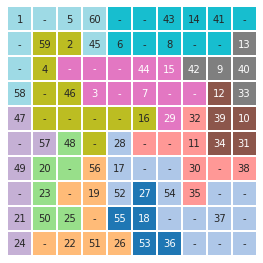

In [14]:
test = Matrix(fixed,groups)
test.solve()

In [30]:
url='https://www.janestreet.com/puzzles/solutions/april-2017-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The knight’s path is presented here, and the solution to this month’s puzzle is 10*9*4*3*2*2*2*2 = 17280 .


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2017/05/Apr17_solution.png" width="300" >